# Objective
- base, Grid-Search-CV, Random-Search-CV models without oversampling
- base, Grid-Search-CV, Random-Search-CV models with oversampling

In [204]:
import warnings
from collections import Counter
from importlib import reload

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

import custom_libs.evaluation_helper as ev
import models.uci_heart_disease_dataset as uci

warnings.filterwarnings("ignore")

In [205]:
# Load the preprocessed dataset (299 records; with 14 features).
data = pd.read_csv(uci.UCIHeartDiseaseDataFile.cleveland_preprocessed, names = uci.get_standard_features())
print(f'Data shape: {data.shape}.')
data.head(3)

Data shape: (299, 14).


,Age,Gender,Chest Pain,BP Systolic,Cholesterol,Blood Sugar,Rest ECG,Exe. Max Heartrate,Exe. Induced Angina,Exe. ST Depression,Exe. ST Segment Slope,Major Vessels,Thalassemia,Target
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286.0,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229.0,0,2,129,1,2.6,2,2,7,1


### Parameters for SVM

In [206]:
# Verbose variable for log inspection.
verbose = False

# Dictionary to hold hyperparameters for grid search.
parameters = dict()
parameters['kernel'] = ['rbf', 'poly', 'linear', 'sigmoid']
# Tried even with 30 - takes longer but still chooses 1.
parameters['C'] = arange(1, 10, 1)
parameters['gamma'] = ['scale', 'auto']
parameters['class_weight'] = ['dict', 'balanced']

# A stratified K fold for cross validation strategy - values are assigned from the global class.
skfolds = StratifiedKFold(n_splits = ev.kfold_n_split,
                          shuffle = ev.kfold_shuffle,
                          random_state = ev.random_state)

# Reset accuracies for SVM
ev.accuracies = {}

### Base Model (Function)

In [207]:
reload(ev)
# A function to build base model.
# Acknowledgement: Code was referenced from Prof. Mafas Raheem's AML lab-8.
def build_and_validate_base_model(x_set, y_set, test_name):
    # Calls the evaluation helper module to Scale and do train/test split.
    x_train, x_test, y_train, y_test = ev.scale_and_split(x_set, y_set)

    print(f'\nEvaluation name: {test_name}.')

    # Train the model with training set.
    svc= SVC(verbose=verbose)
    svc.fit(x_train, y_train)

    # Do prediction with the train model.
    y_pred = svc.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve
    ev.display_validation_report(y_test, y_pred, x_test, svc, test_name)

### Grid Search CV (Function)

In [208]:
reload(ev)
# A function to build and fine tune model using GridSearchCV.
# Acknowledgement: Code was referenced from Prof. Mafas Raheem's AML lab-8.
def build_and_validate_with_grid_search_cv(x_set, y_set, test_name):
    # Calls the evaluation helper module to Scale and do train/test split.
    x_train, x_test, y_train, y_test = ev.scale_and_split(x_set, y_set)

    print(f'\nEvaluation name: {test_name}.')

    grid_svc= SVC(verbose=verbose)

    ## Building Grid Search algorithm with cross-validation and acc score.
    grid_search_svc = GridSearchCV(grid_svc, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's hyperparameters for optimal result.
    grid_search_svc.fit(x_train,y_train)

    # Display the best hyperparameters and score.
    print(f'Best params          :{grid_search_svc.best_params_}.')
    print(f'Best score (*mean)   :{grid_search_svc.best_score_}.')

    # Predict using the trained model.
    y_pred = grid_search_svc.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve
    ev.display_validation_report(y_test, y_pred, x_test, grid_search_svc, test_name)

### Random Search CV (Function)

In [209]:
reload(ev)
# A function to build and fine tune model using RandomSearchCV.
# Acknowledgement: Code was referenced from Prof. Mafas Raheem's AML lab-8.
def build_and_validate_with_random_search_cv(x_set, y_set, test_name):
    # Calls the evaluation helper module to Scale and do train/test split.
    x_train, x_test, y_train, y_test = ev.scale_and_split(x_set, y_set)

    print(f'\nEvaluation name: {test_name}.')

    rand_svc= SVC(verbose=verbose)

    ## Building Random Search algorithm with cross-validation and acc score.
    rand_search_svc = RandomizedSearchCV(rand_svc, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's hyperparameters for optimal result.
    rand_search_svc.fit(x_train,y_train)

    # Display the best hyperparameters and score.
    print(f'Best params :{rand_search_svc.best_params_}.')
    print(f'Best score  :{rand_search_svc.best_score_}.')

    # Predict using the trained model.
    y_pred = rand_search_svc.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve
    ev.display_validation_report(y_test, y_pred, x_test, rand_search_svc, test_name)

## Evaluation with Standard Dataset (without over-sampling)

### Data Preparation

In [210]:
# Prepare features and target variables.
X = data.drop(uci.UCIHeartDiseaseData.target, axis=1)
y = data[uci.UCIHeartDiseaseData.target]


Evaluation name: std-base.

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        32
           1       0.85      0.82      0.84        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60


Confusion Matrix


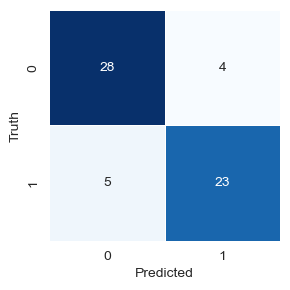

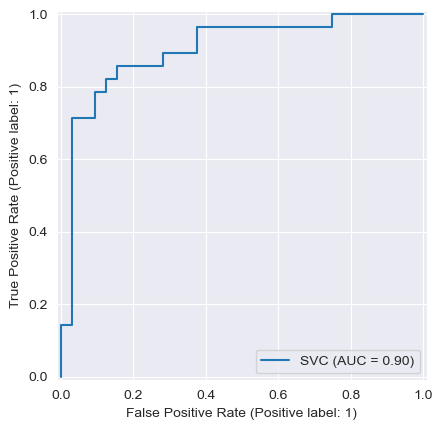

In [211]:
# Evaluation: Standard Base
build_and_validate_base_model(X, y,ev.EvaluationType.std_base)


Evaluation name: std-grid-scv.
Best params          :{'C': 2, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}.
Best score (*mean)   :0.8286347517730498.

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        32
           1       0.86      0.86      0.86        28

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60


Confusion Matrix


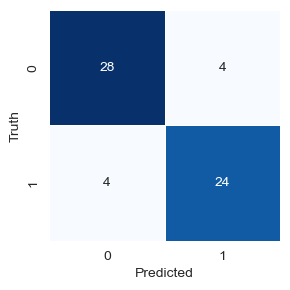

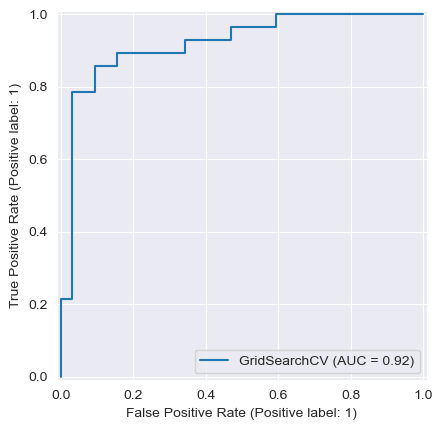

In [212]:
# Evaluation: Standard Grid Search CV
build_and_validate_with_grid_search_cv(X, y, ev.EvaluationType.std_grid_search_cv)


Evaluation name: std-rand-scv.
Best params :{'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 5}.
Best score  :0.7696808510638298.

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.72      0.77        32
           1       0.72      0.82      0.77        28

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.77      0.77      0.77        60


Confusion Matrix


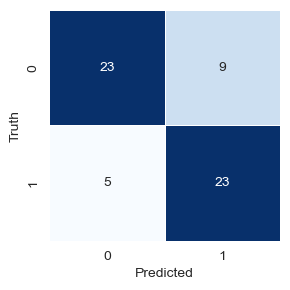

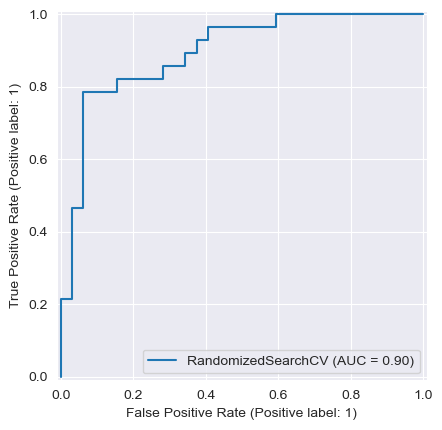

In [213]:
# Evaluation: Standard Random Search CV
build_and_validate_with_random_search_cv(X, y, ev.EvaluationType.std_random_search_cv)

In [214]:
print(ev.accuracies)

{'std-base': 85, 'std-grid-scv': 87, 'std-rand-scv': 77}


## Evaluation with Over-sampled Dataset

### Data Preparation and Over-sampling

In [215]:
# Prepare features and target variables.
X = data.drop(uci.UCIHeartDiseaseData.target, axis=1)
y = data[uci.UCIHeartDiseaseData.target]

# Perform over-sampling with SMOTE
X_b, y_b = SMOTE().fit_resample(X, y)
print(f'Classes before over-sampling :{Counter(data[uci.UCIHeartDiseaseData.target])}.')
print(f'Classes after over-sampling  :{Counter(y_b)}.')

Classes before over-sampling :Counter({0: 160, 1: 139}).
Classes after over-sampling  :Counter({0: 160, 1: 160}).


<Axes: xlabel='Target', ylabel='count'>

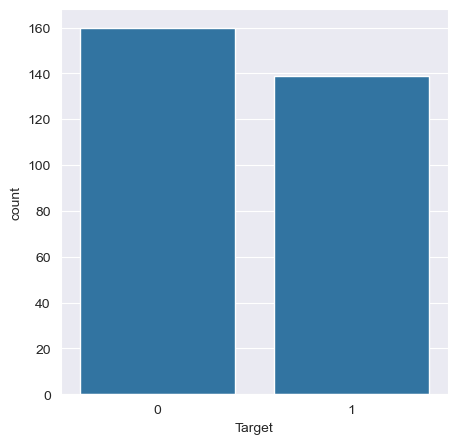

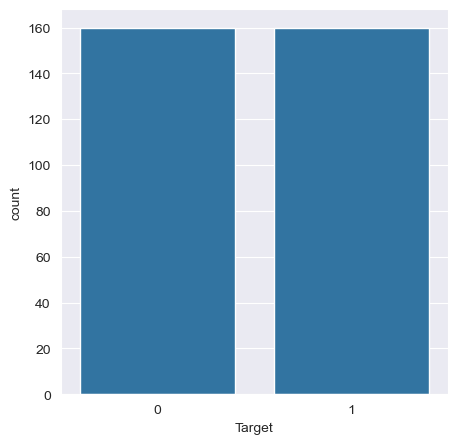

In [216]:
# Before over-sampling
plt.subplots(figsize=(5,5))
sns.countplot(x=data[uci.UCIHeartDiseaseData.target])

# After over-sampling
plt.subplots(figsize=(5,5))
sns.countplot(x=y_b)


Evaluation name: os-base.

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.78      0.76        32
           1       0.77      0.72      0.74        32

    accuracy                           0.75        64
   macro avg       0.75      0.75      0.75        64
weighted avg       0.75      0.75      0.75        64


Confusion Matrix


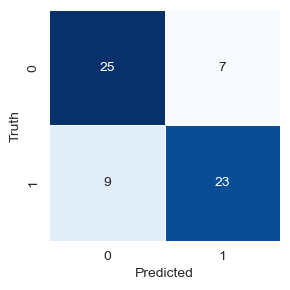

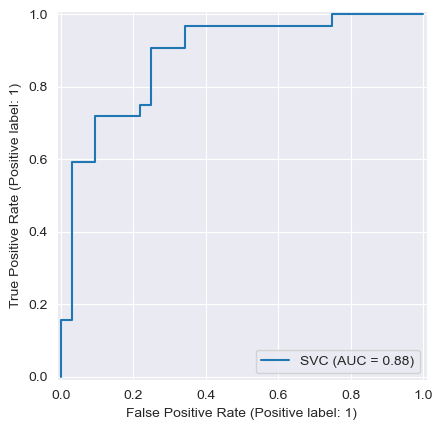

In [217]:
# Evaluation: Over-sampled Base
build_and_validate_base_model(X_b, y_b,ev.EvaluationType.os_base)


Evaluation name: os-grid-scv.
Best params          :{'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}.
Best score (*mean)   :0.8203619909502262.

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.78      0.76        32
           1       0.77      0.72      0.74        32

    accuracy                           0.75        64
   macro avg       0.75      0.75      0.75        64
weighted avg       0.75      0.75      0.75        64


Confusion Matrix


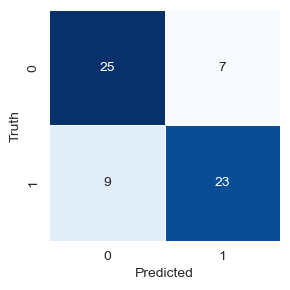

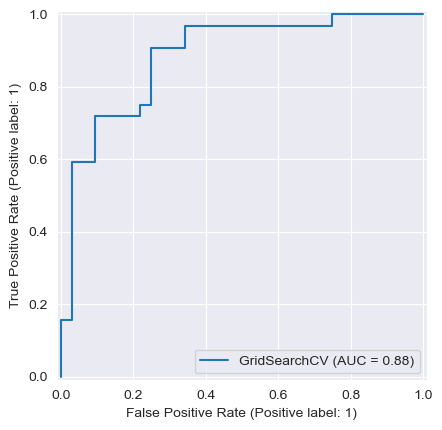

In [218]:
# Evaluation: Over-sampled Grid Search CV
build_and_validate_with_grid_search_cv(X_b, y_b, ev.EvaluationType.os_grid_search_cv)


Evaluation name: os-rand-scv.
Best params :{'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'C': 1}.
Best score  :0.8124434389140271.

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        32
           1       0.86      0.78      0.82        32

    accuracy                           0.83        64
   macro avg       0.83      0.83      0.83        64
weighted avg       0.83      0.83      0.83        64


Confusion Matrix


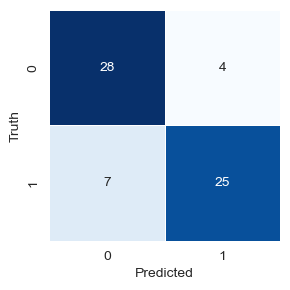

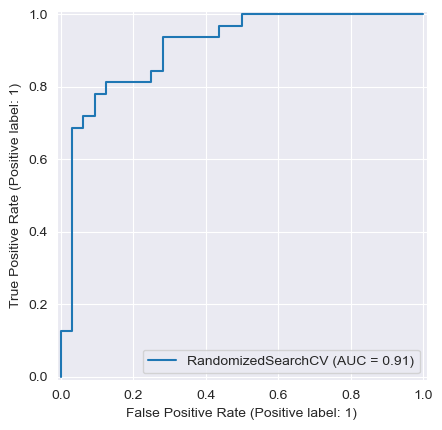

In [219]:
# Evaluation: Over-sampled Random Search CV
build_and_validate_with_random_search_cv(X_b, y_b, ev.EvaluationType.os_random_search_cv)

In [220]:
print(ev.accuracies)

{'std-base': 85, 'std-grid-scv': 87, 'std-rand-scv': 77, 'os-base': 75, 'os-grid-scv': 75, 'os-rand-scv': 83}


## Conclusion

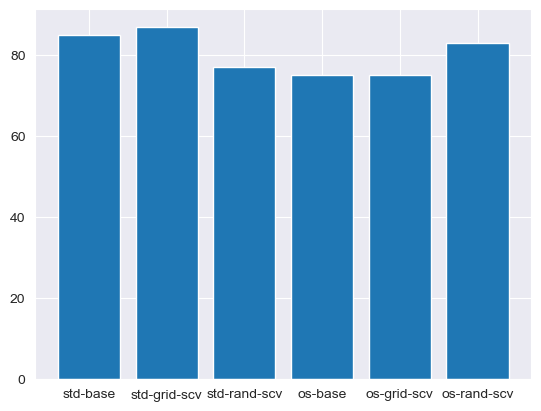

In [221]:
plt.bar(range(len(ev.accuracies)), list(ev.accuracies.values()), align='center')
plt.xticks(range(len(ev.accuracies)), list(ev.accuracies.keys()))

plt.show()

In [222]:
### Register the highest in global
ev.global_accuracies['SVM'] = 87